Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Config

In [3]:
labeled_path = "../data/labels.parquet"

Loading Dataset

In [4]:
dataset = pd.read_parquet(labeled_path)
dataset.head()

Location       Date  Demand
0         1 2023-01-01    40.0
1         1 2023-01-02    31.0
2         1 2023-01-03    27.0
3         1 2023-01-04     7.0
4         1 2023-01-05    15.0

Evaluation

Generate temporary predicted Data

In [5]:
def generate_temporary_prediction(dataset):
    predicted_demand = dataset.Demand.shift(1)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Demand'] = predicted_demand
    return predicted_data


In [6]:
predicted_data = generate_temporary_prediction(dataset)
predicted_data = predicted_data.dropna()
predicted_data.head()

Location       Date  Demand
1         1 2023-01-02    40.0
2         1 2023-01-03    31.0
3         1 2023-01-04    27.0
4         1 2023-01-05     7.0
5         1 2023-01-06    15.0

calculate loss functions

In [7]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_mape(actual_data, predicted_data, fix_inf = 1):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    fix_inf_val = np.where(losses_df['actual_demand']==0, fix_inf, losses_df['actual_demand'])    
    losses_df['error'] = ((np.abs(losses_df['actual_demand']-losses_df['predicted_demand']))/
                          (losses_df['actual_demand']+fix_inf_val))*100

    loss_per_location = (losses_df.groupby('Location')
                                        .agg({'actual_demand':'mean', 
                                            'predicted_demand':'mean', 
                                            'error':'mean'}))
    loss_per_date = (losses_df.groupby('Date')
                                    .agg({'actual_demand':'mean', 
                                        'predicted_demand':'mean', 
                                        'error':'mean'}))

    losses_df['day_of_week'] = losses_df['Date'].dt.dayofweek
    loss_per_dayofweek = (losses_df.groupby('day_of_week')
                                        .agg({'actual_demand':'mean', 
                                            'predicted_demand':'mean', 
                                            'error':'mean'}))

    return loss_per_location, loss_per_date, loss_per_dayofweek


In [65]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_rmse(actual_data, predicted_data):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    losses_df['error'] = np.square(np.subtract(losses_df['actual_demand'],losses_df['predicted_demand']))

    loss_per_location = np.sqrt(losses_df.groupby('Location')
                                .agg({'actual_demand':'mean', 
                                      'predicted_demand':'mean', 
                                      'error':'mean'}))
    
    loss_per_date = np.sqrt(losses_df.groupby('Date')
                            .agg({'actual_demand':'mean', 
                                'predicted_demand':'mean', 
                                'error':'mean'}))
    
    losses_df['day_of_week'] = losses_df['Date'].dt.dayofweek
    loss_per_dayofweek = np.sqrt(losses_df.groupby('day_of_week')
                                 .agg({'actual_demand':'mean', 
                                      'predicted_demand':'mean', 
                                      'error':'mean'}))

    return loss_per_location, loss_per_date, loss_per_dayofweek


Plot accuracies function

In [64]:
%matplotlib inline
def plot_acc(losses: pd.DataFrame, label, method, min_threshold, mean_threshold):
    error_df = losses.reset_index()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

    ind_name = error_df.columns[0]
    
    plot_error_df = error_df[[ind_name,'error']].copy()
    plot_demand_df = error_df[[ind_name,'predicted_demand']].copy()

    min_threshold_line_df = pd.DataFrame(min_threshold,
                                          index=plot_error_df[ind_name], 
                                          columns=['min_error']).reset_index()
    mean_threshold_line_df = pd.DataFrame(mean_threshold, 
                                          index=plot_error_df[ind_name], 
                                          columns=['mean_error']).reset_index()
    
    plot_error_df.plot(x=ind_name, y='error', ax=axes, color='red', kind='line')
    min_threshold_line_df.plot(x=ind_name, y='min_error', ax=axes, color='yellow', kind='line')
    mean_threshold_line_df.plot(x=ind_name, y='mean_error', ax=axes, color='blue', kind='line')
    
    if method == 'rmse':
        plot_demand_df.plot(x=ind_name, y='predicted_demand', ax=axes, color='green', kind='line')
    
    plt.legend(['error','min_error','mean_error','predicted_demand'])
    plt.xlabel(str(label))
    title = 'Model Error per ' + str(label) + ' using method ' + str(method)
    plt.title(title)

    plt.show()

Evaluate Model function

In [30]:
def prepare_report(losses: pd.DataFrame, plot_label, method, error_limit):
    min_threshold = losses.min()['error']
    max_threshold = losses.max()['error']
    mean_threshold = losses.mean()['error']

    report_dict = {
            'best_accuracy': min_threshold,
            'best_accuracy_point': [losses['error'].idxmin()],
            'worst_accuracy': max_threshold,
            'worst_accuracy_point': [losses['error'].idxmax()],
            'mean_accuracy': mean_threshold
        }
    
    if error_limit>0 :
        losses['error'] = (np.where(losses['error']>error_limit, error_limit, losses['error']))
    
    plot_acc(losses, plot_label, method, min_threshold, mean_threshold)

    return report_dict

In [29]:
def evaluate_model(dataset, predicted_data, method, error_limit):
    if method == 'mape':
        loss_per_location, loss_per_date, loss_per_dayofweek = calculate_loss_mape(dataset, predicted_data)
    elif method == 'rmse':
        loss_per_location, loss_per_date, loss_per_dayofweek = calculate_loss_rmse(dataset, predicted_data)
    else:
        return "bad method request"
    
    date_report_df = pd.DataFrame(prepare_report(loss_per_date, 'date', method, error_limit))
    loc_report_df = pd.DataFrame(prepare_report(loss_per_location, 'location', method, error_limit))
    dayofweek_report_df = pd.DataFrame(prepare_report(loss_per_dayofweek, 'day of the week', method, error_limit))
    
    return(date_report_df, loc_report_df, dayofweek_report_df)

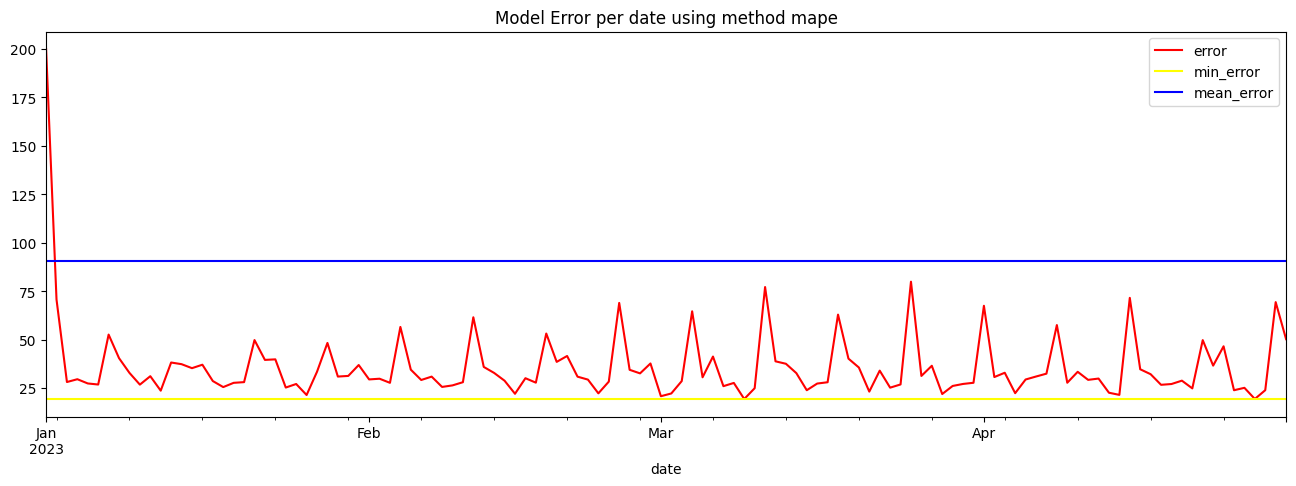

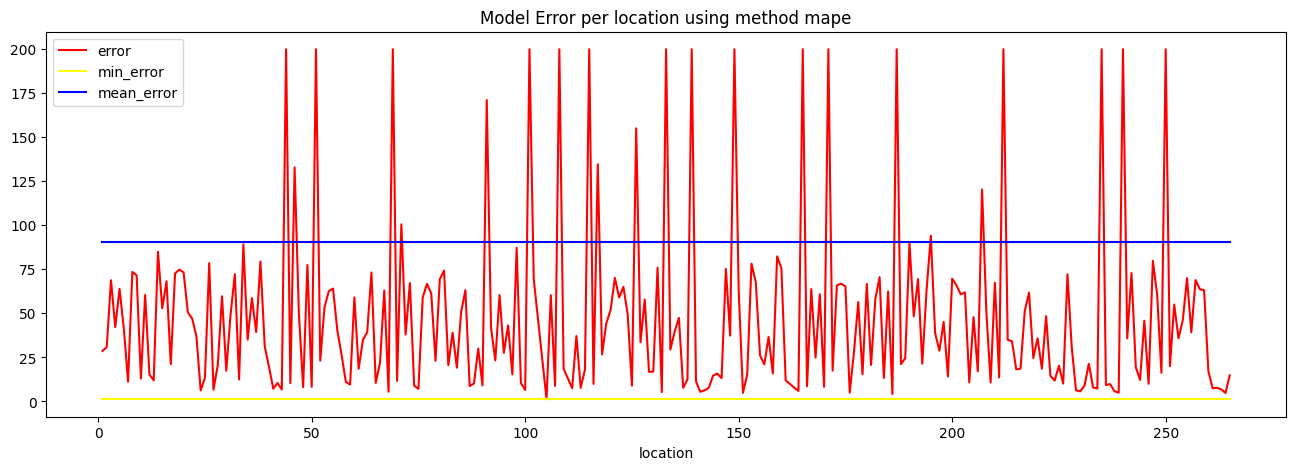

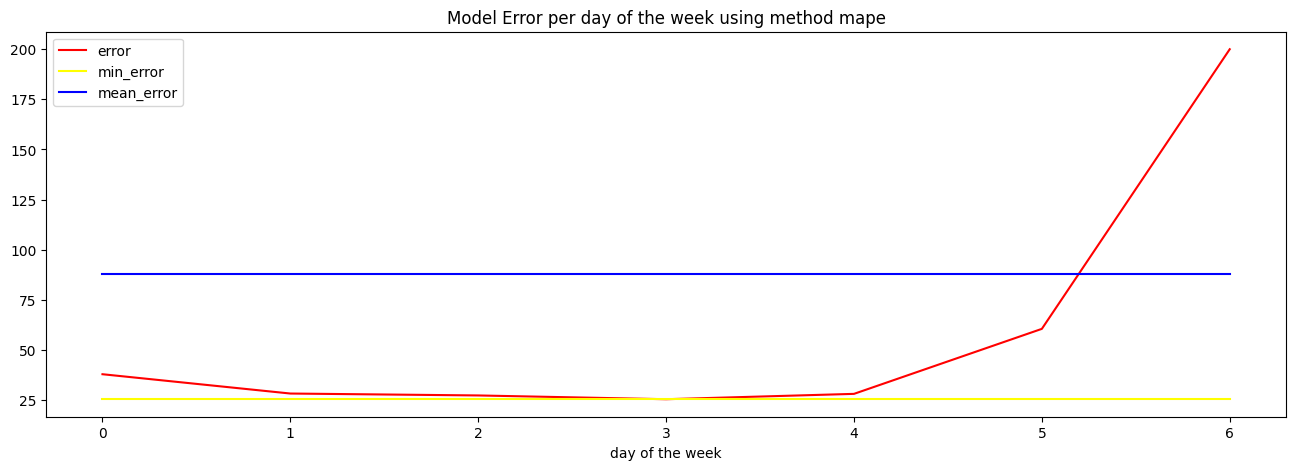

In [61]:
date_report_df, loc_report_df, dayofweek_report_df = evaluate_model(dataset, predicted_data, 'mape', 200)

In [38]:
print('mape per date')
date_report_df.head()

mape per date


best_accuracy best_accuracy_point  worst_accuracy worst_accuracy_point  \
0       19.35741          2023-03-09     6750.540743           2023-01-01   

   mean_accuracy  
0       90.72366

In [39]:
print("mape per location")
loc_report_df.head()

mape per location


best_accuracy  best_accuracy_point  worst_accuracy  worst_accuracy_point  \
0           1.25                  105     2794.583333                   187   

   mean_accuracy  
0      90.509859

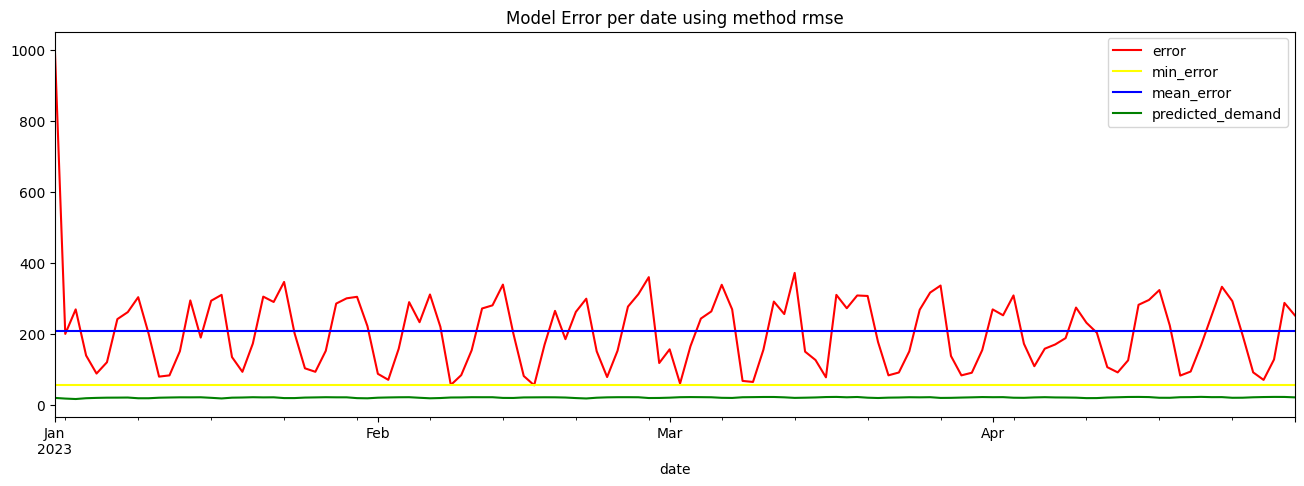

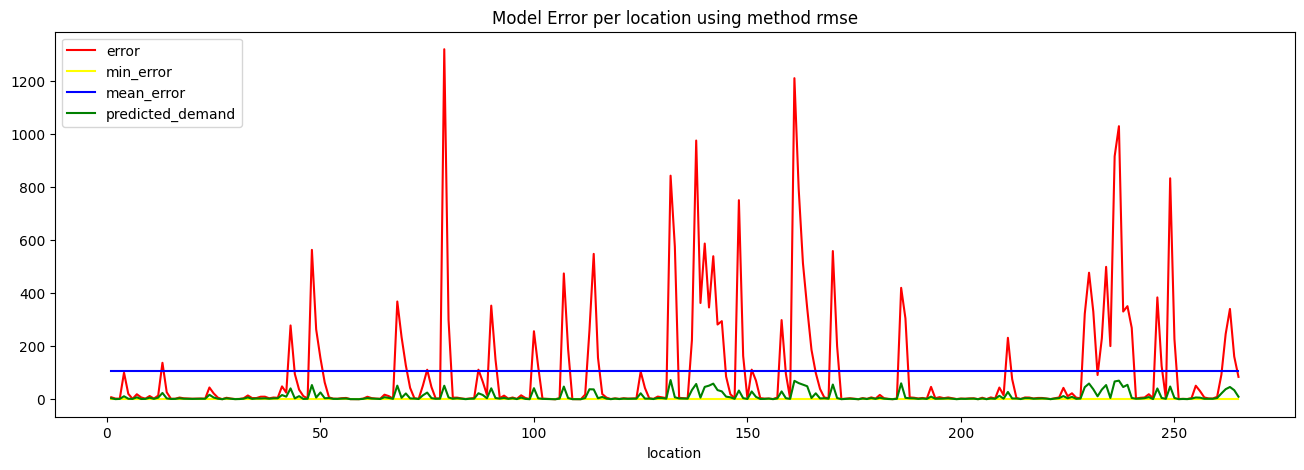

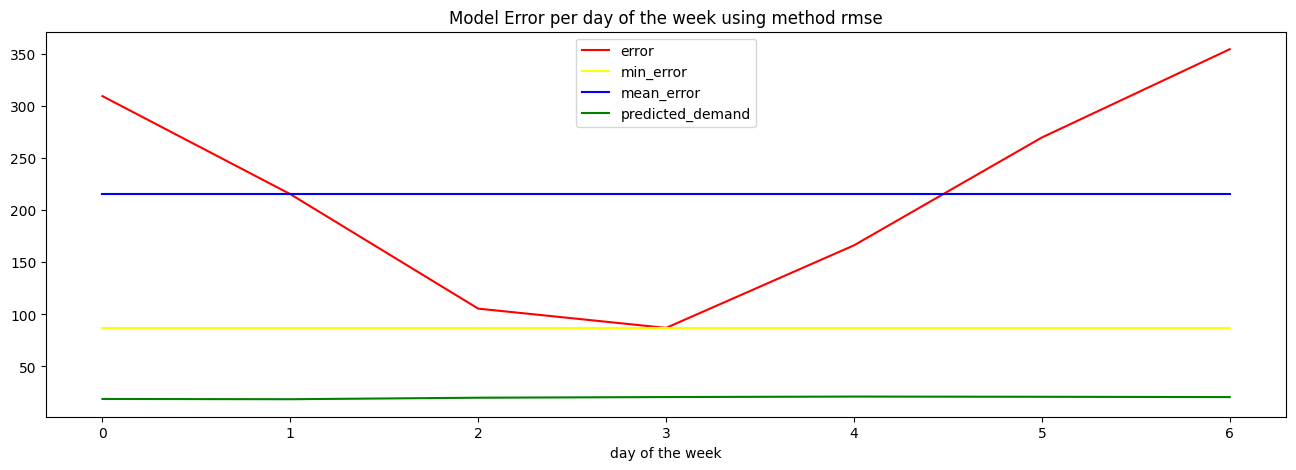

In [62]:
date_rmse_report_df, loc_rmse_report_df, dow_rmse_report_df = evaluate_model(dataset, predicted_data, 'rmse', 0)

In [41]:
print('rmse per date')
date_rmse_report_df.head()

rmse per date


best_accuracy best_accuracy_point  worst_accuracy worst_accuracy_point  \
0      54.575671          2023-02-16     1001.368112           2023-01-01   

   mean_accuracy  
0     206.934362

In [42]:
print("rmse per location")
loc_rmse_report_df.head()

rmse per location


best_accuracy  best_accuracy_point  worst_accuracy  worst_accuracy_point  \
0       0.129099                  105      1319.70007                    79   

   mean_accuracy  
0     104.835666

In [43]:
print("rmse per day of the week")
dow_rmse_report_df.head()

rmse per day of the week


best_accuracy  best_accuracy_point  worst_accuracy  worst_accuracy_point  \
0      87.046748                    3      354.760593                     6   

   mean_accuracy  
0     215.555551

plot actual and predicted demand

In [284]:
%matplotlib inline
def plot_actual_predicted(actual_data, predicted_data):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    demand_per_location_sorted = (losses_df.groupby('Location')
                                .agg({'actual_demand':'mean', 
                                      'predicted_demand':'mean'}))
    
    location_num = len(demand_per_location_sorted)
    loc_per_plot = 10

    for i in range(0, location_num, loc_per_plot):
        plot_locations = demand_per_location_sorted[i:i+loc_per_plot].reset_index()
        
        plot_df = losses_df[losses_df['Location'].isin(plot_locations['Location'])] 
        test_plot_df = plot_df.groupby(['Location'])
        
        fig, ax = plt.subplots(1,1,figsize=(16,5))
        for l in plot_locations['Location']:
            loc_plot_df = test_plot_df.get_group(l)
            loc,_ = ax.plot(loc_plot_df['Date'],
                    loc_plot_df[['actual_demand','predicted_demand']],
                    label=str(l))
            
        title = ('actual demand and predicted demand in locations ' + 
                    str(i) + ' to ' + str(i+loc_per_plot-1) + ' in dates')
        plt.title(title)

        plt.show()
        

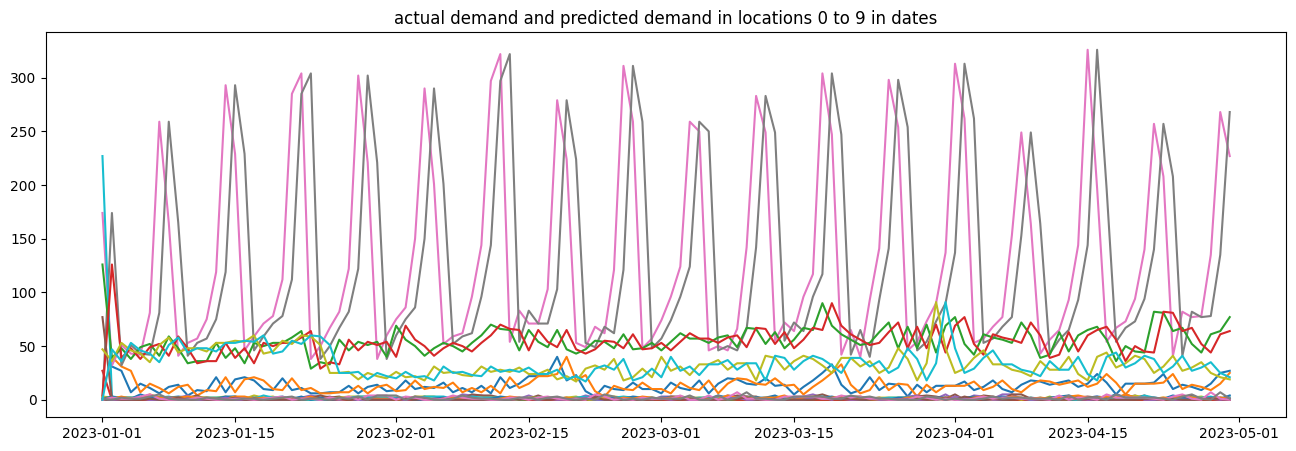

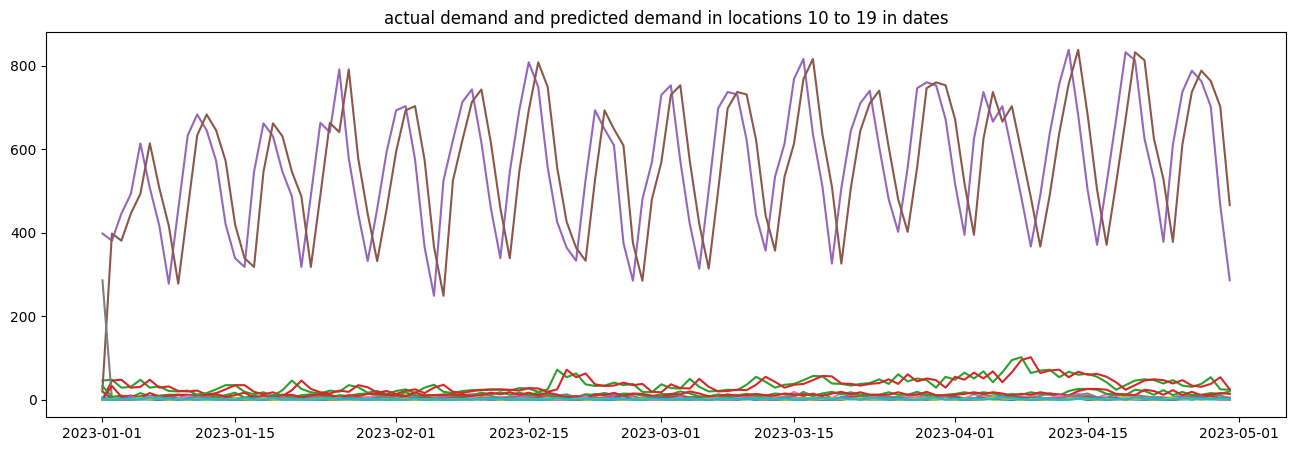

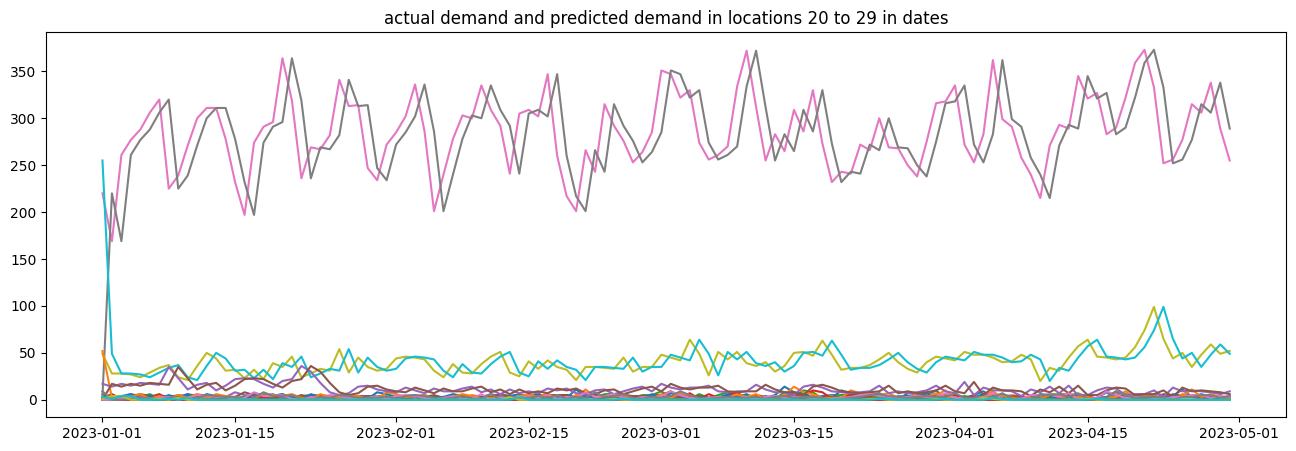

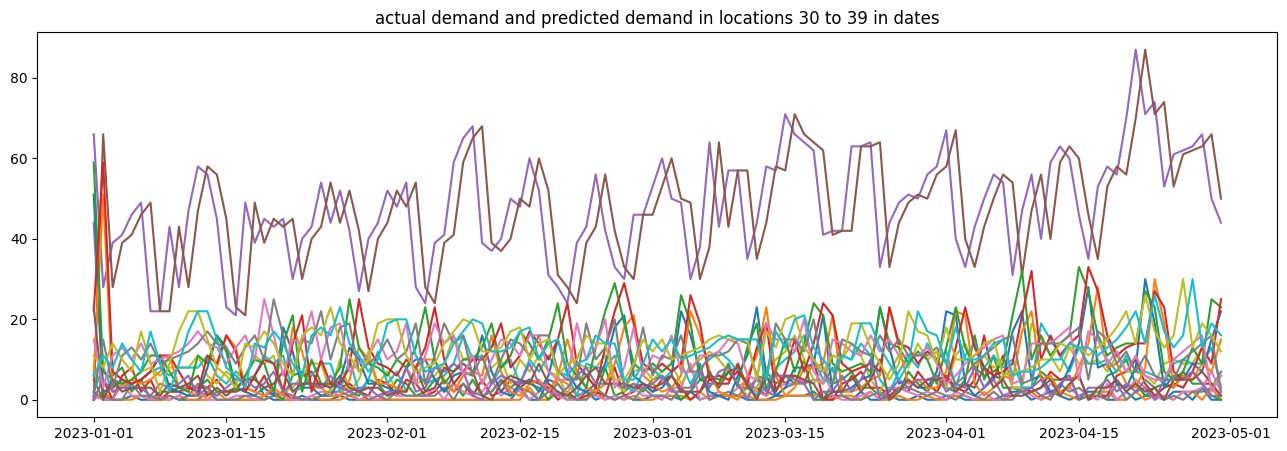

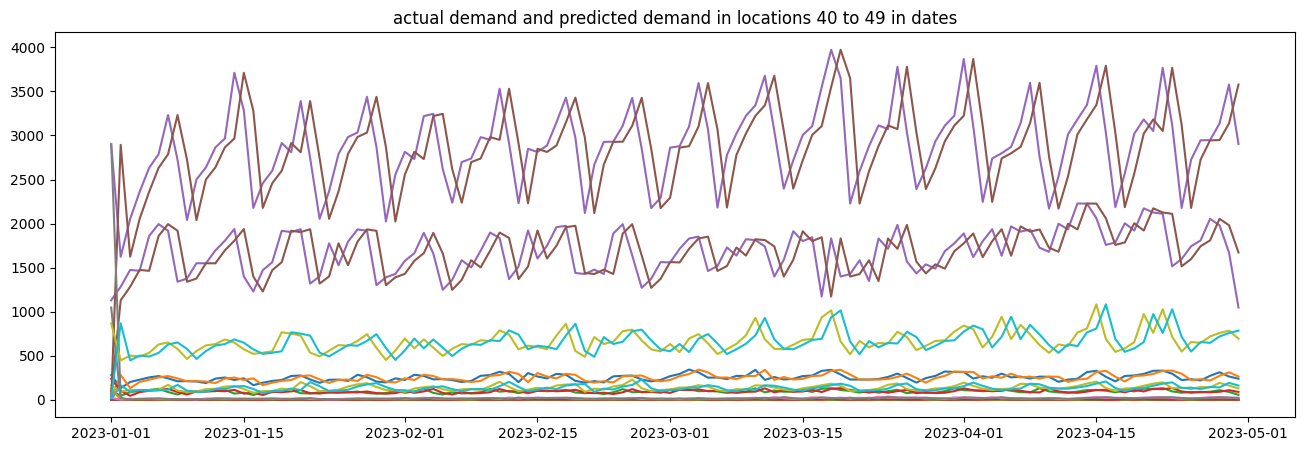

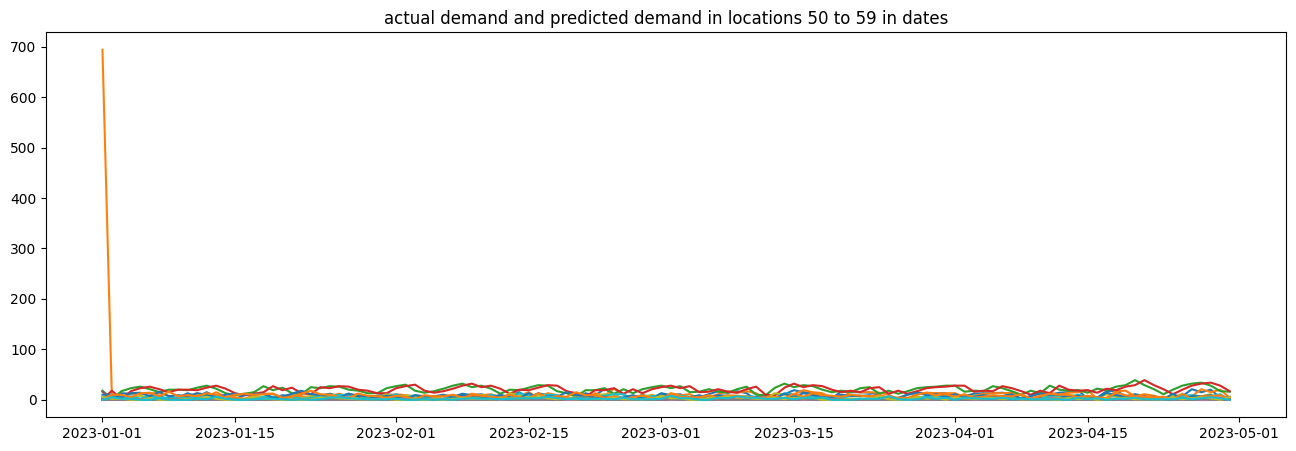

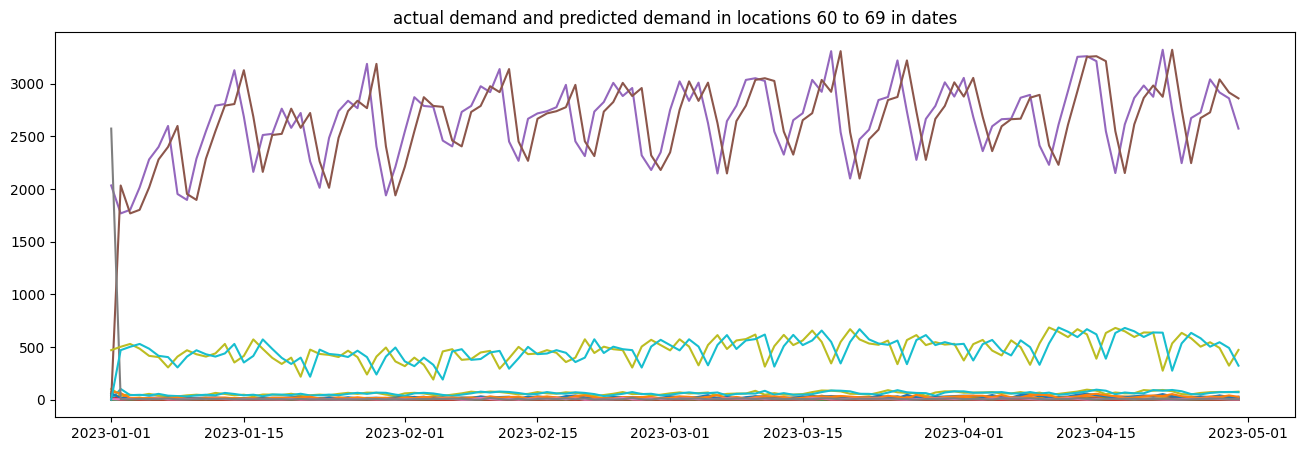

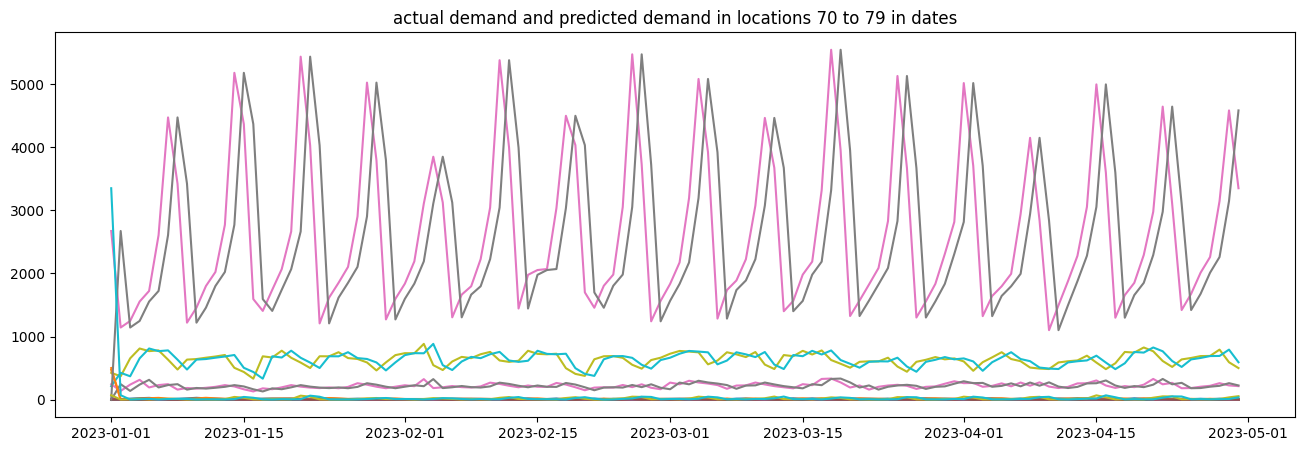

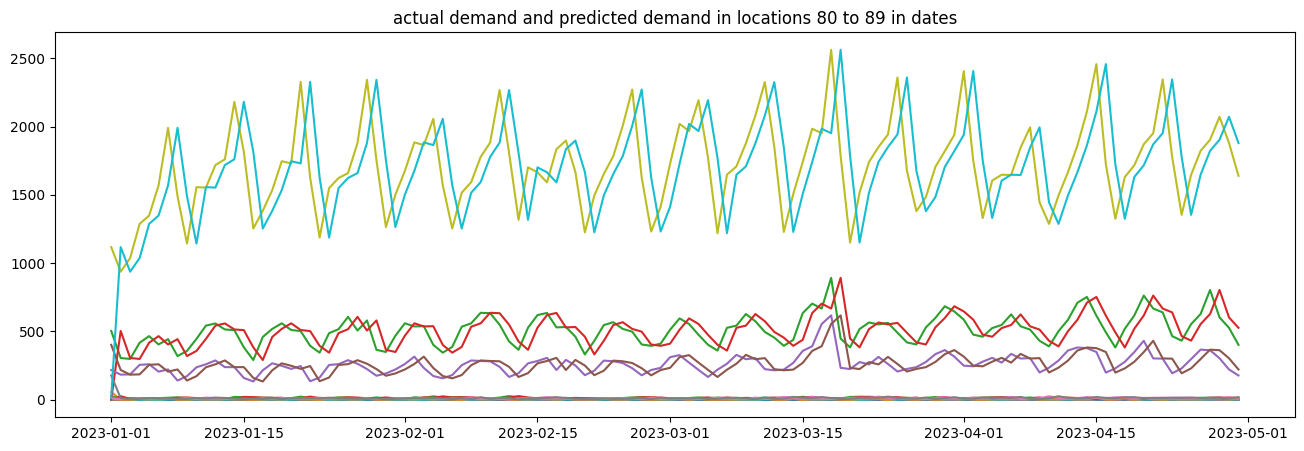

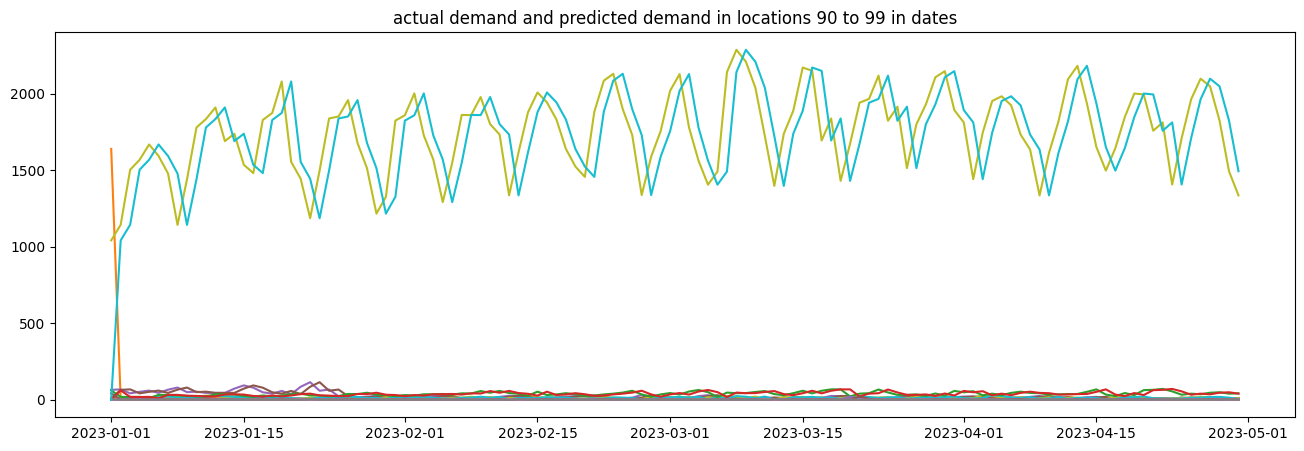

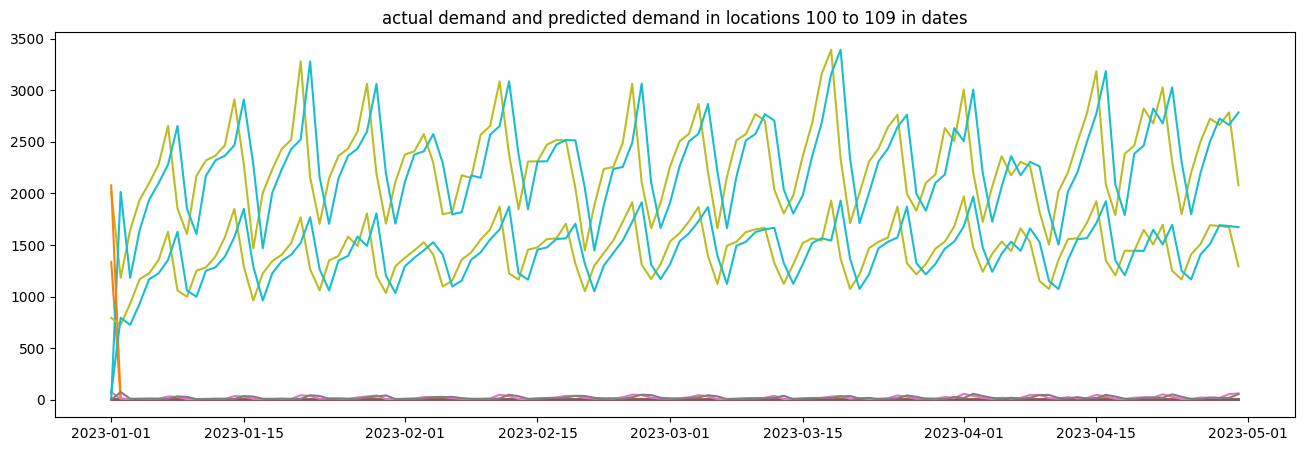

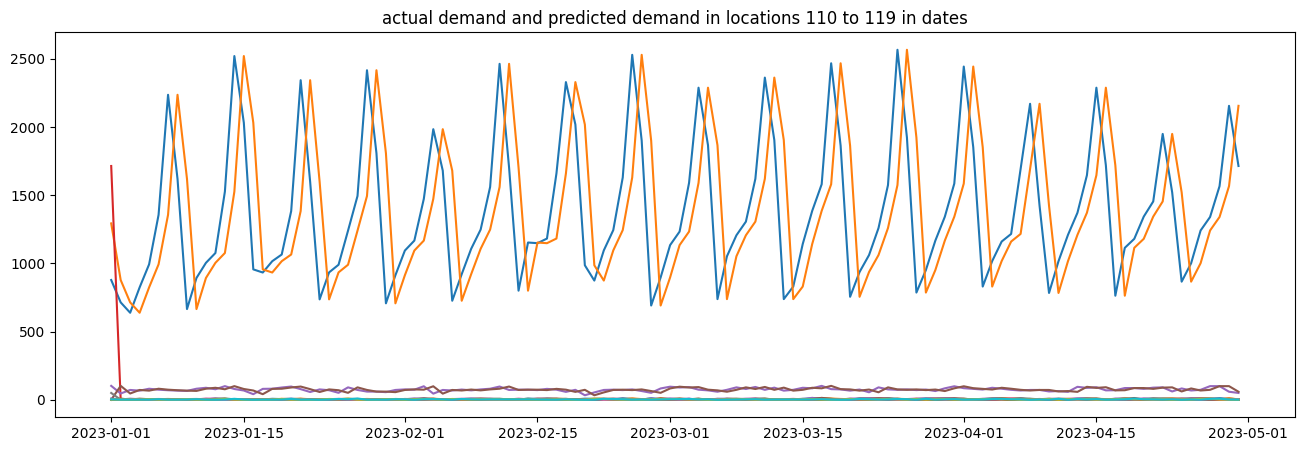

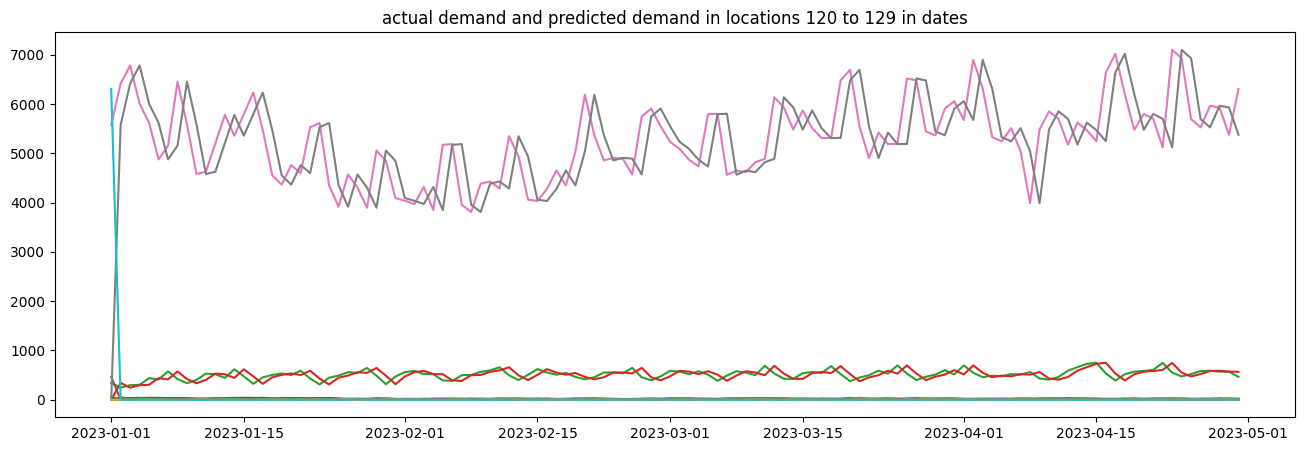

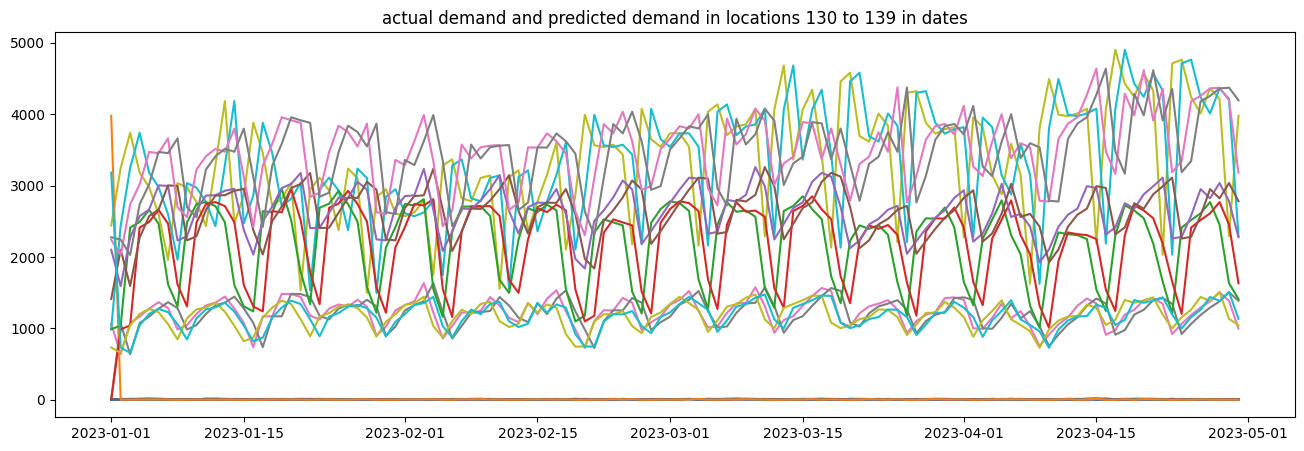

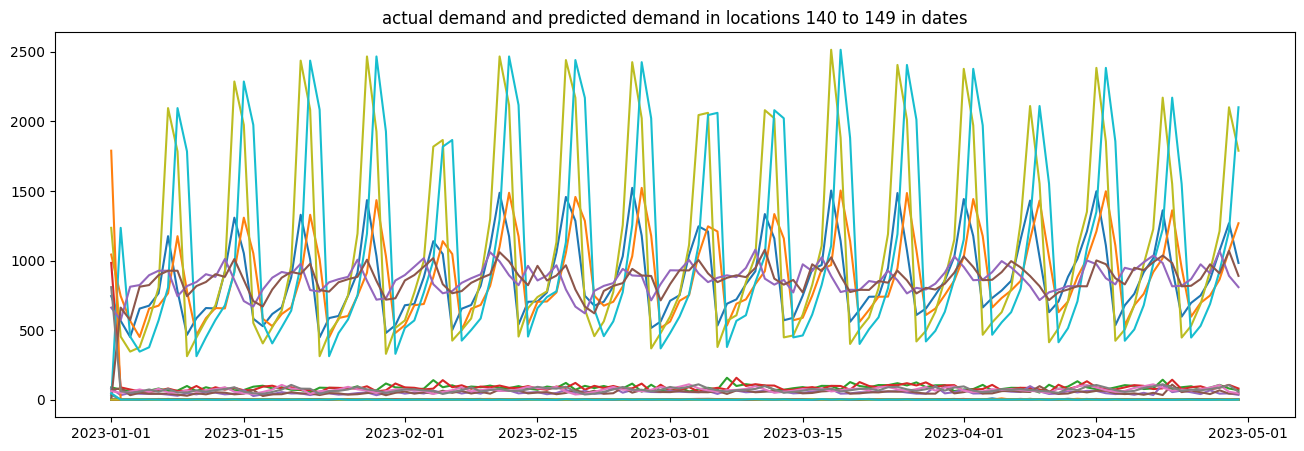

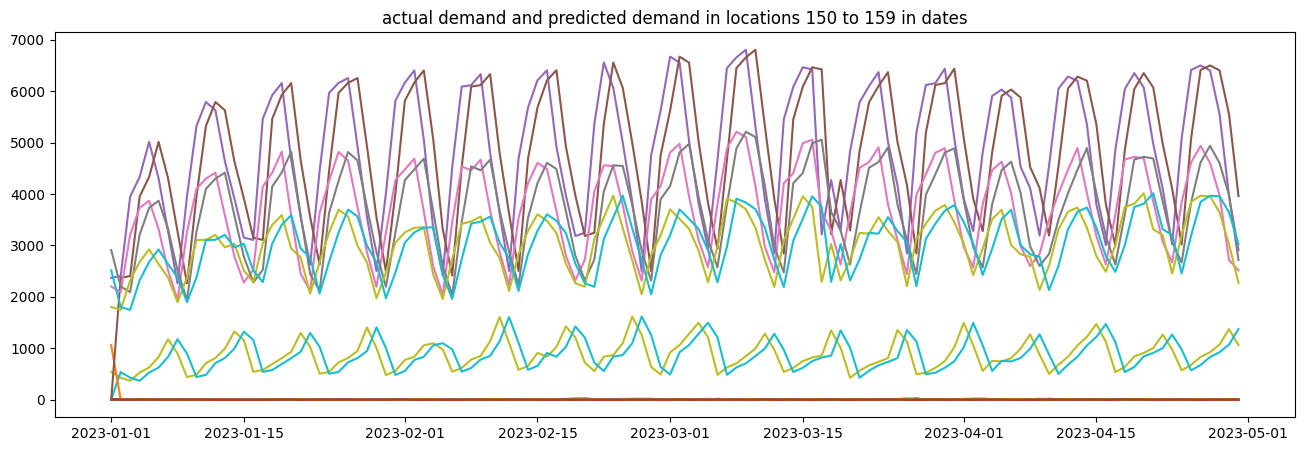

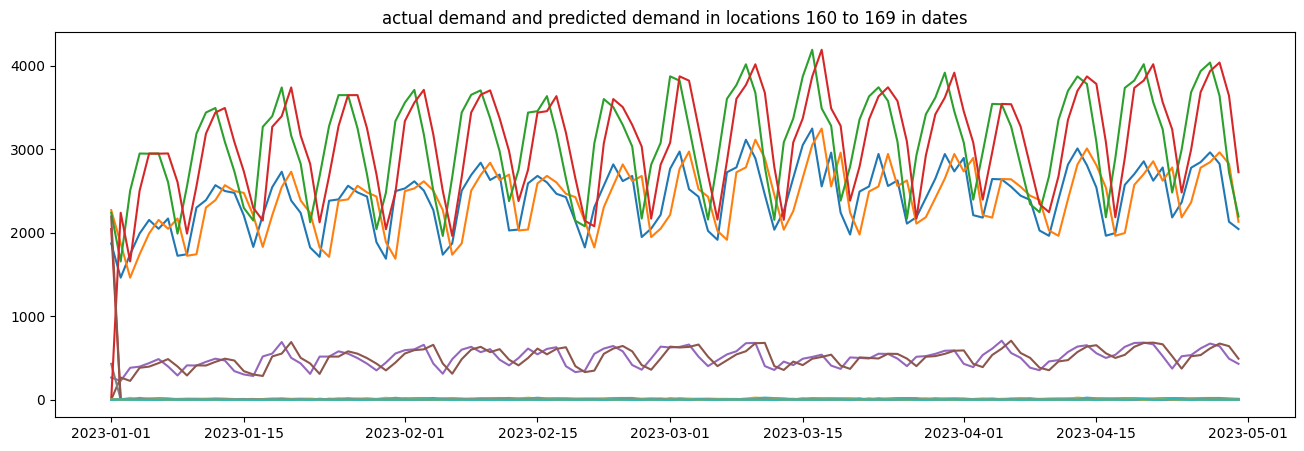

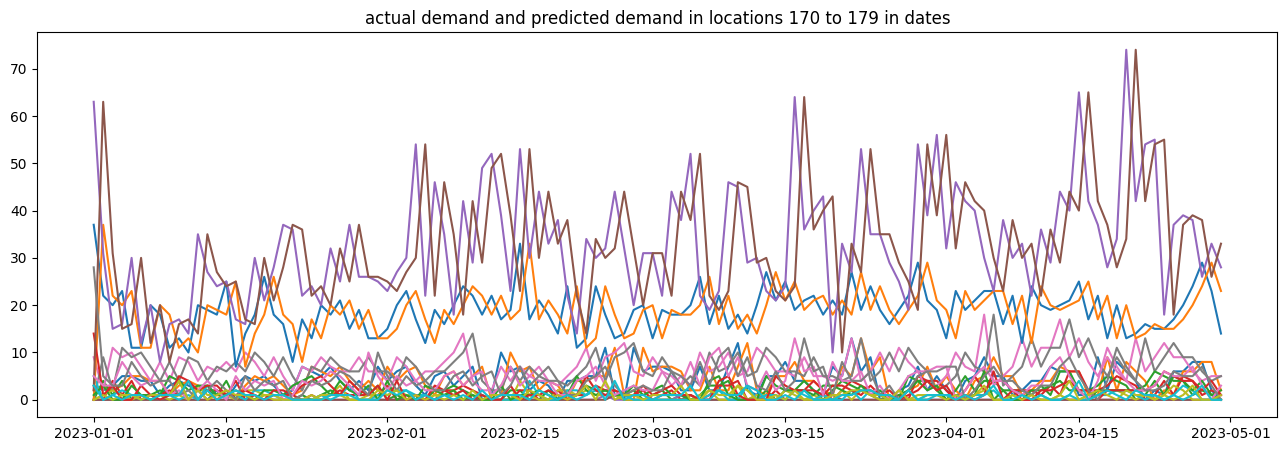

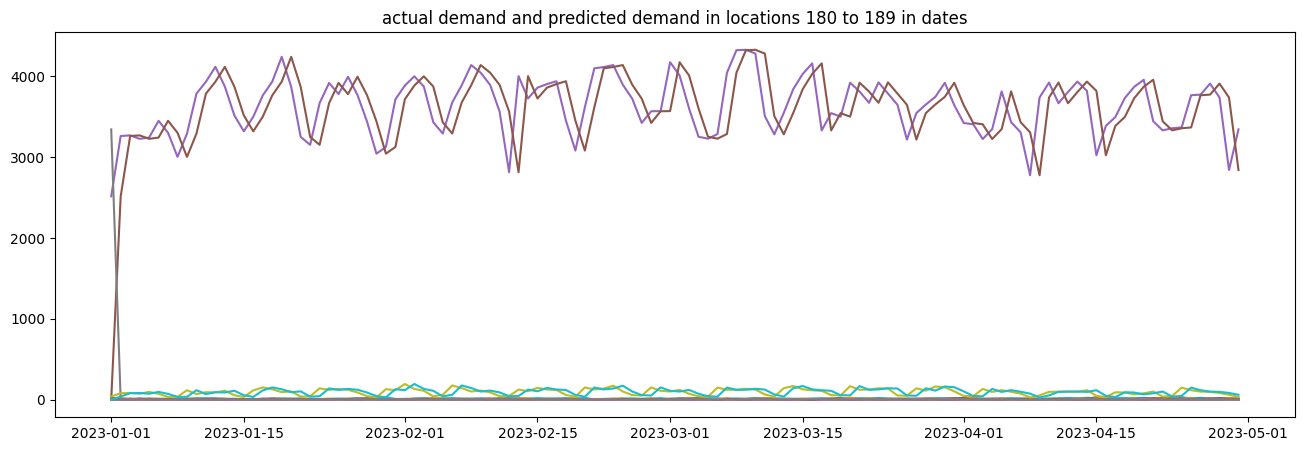

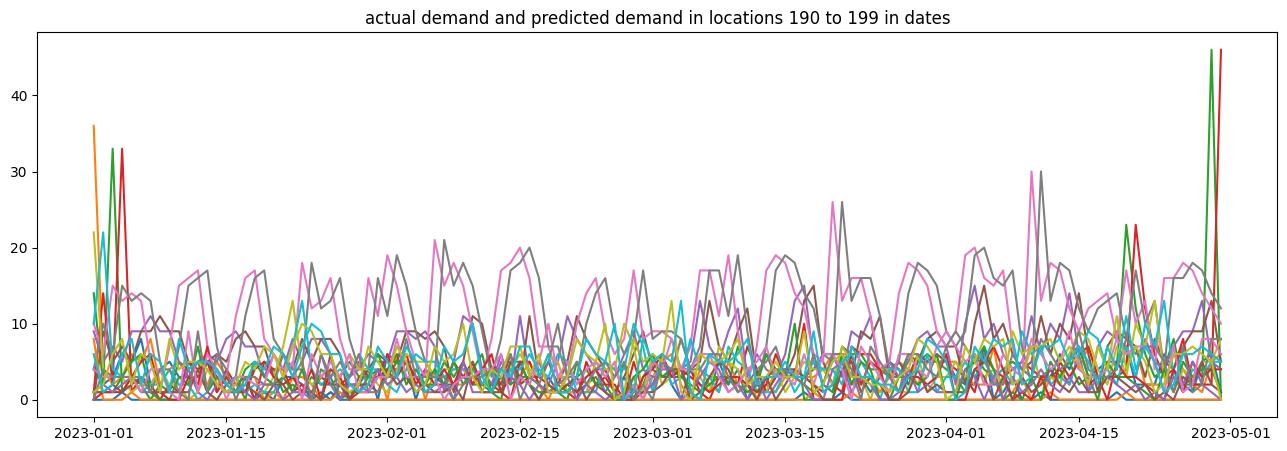

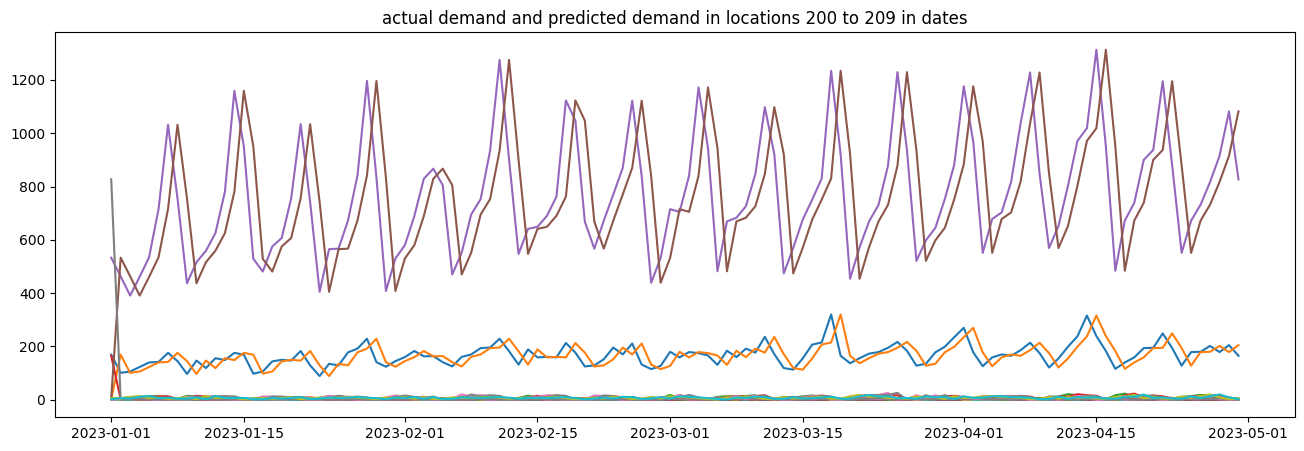

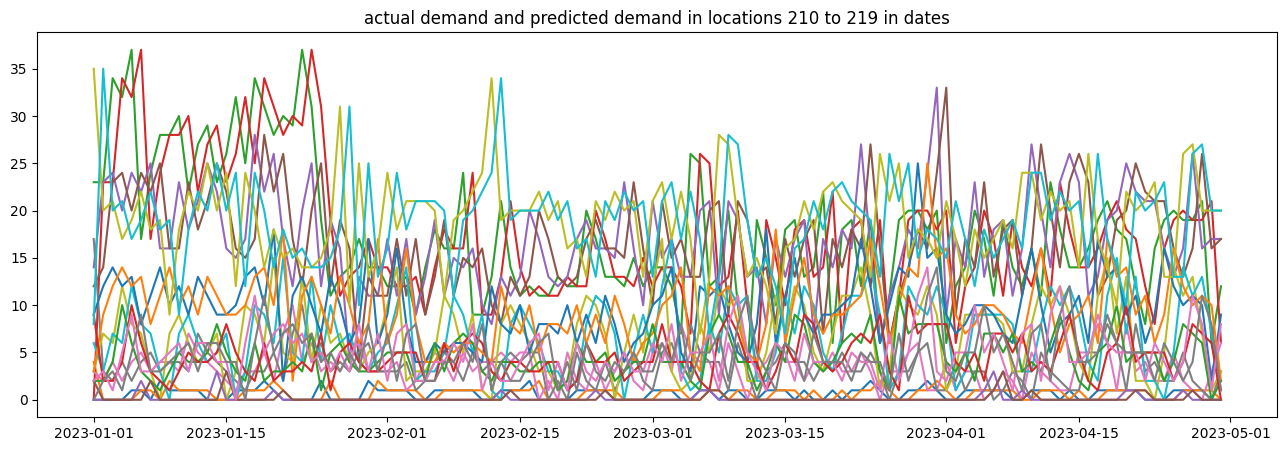

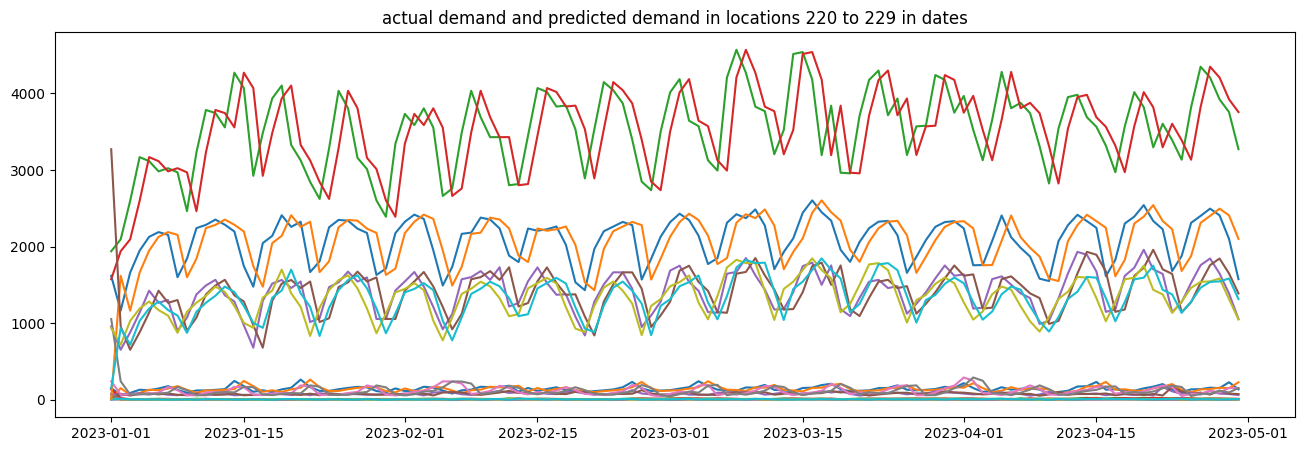

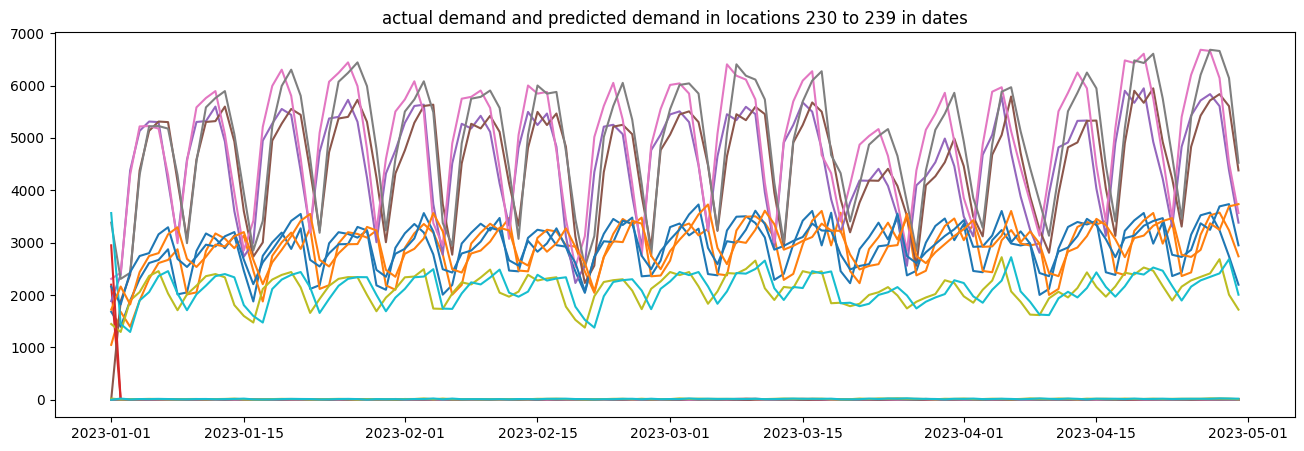

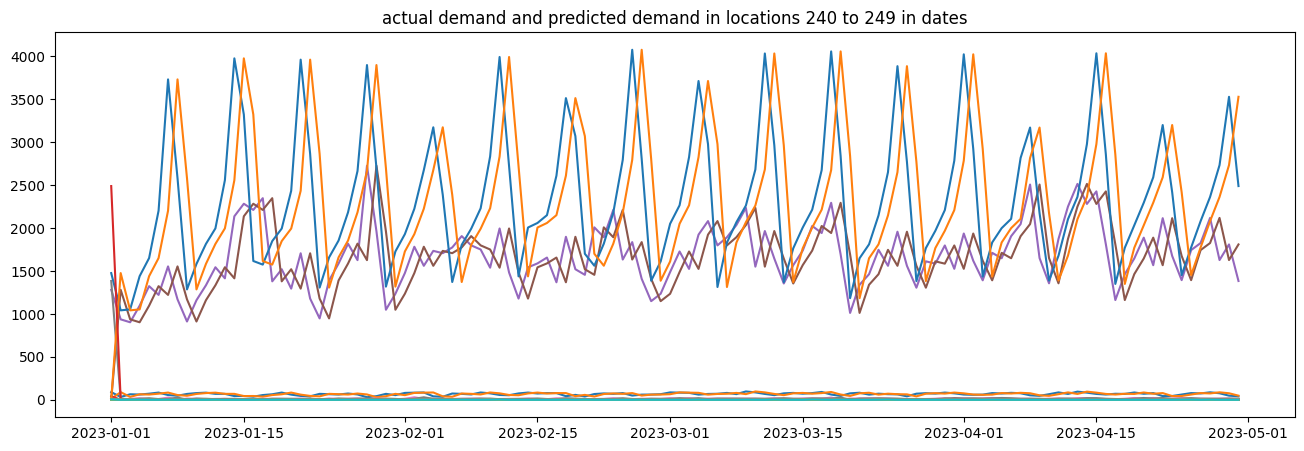

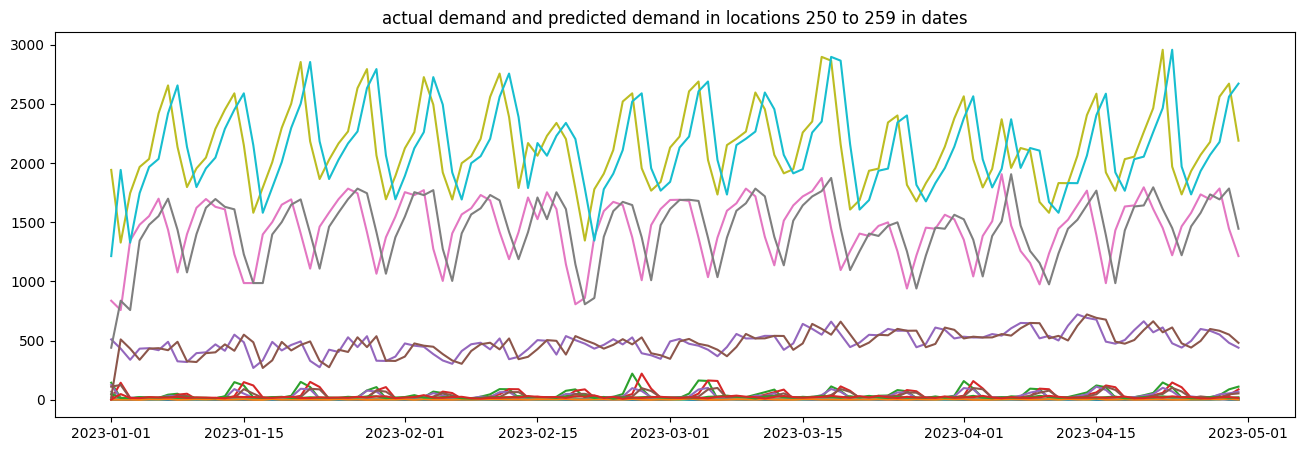

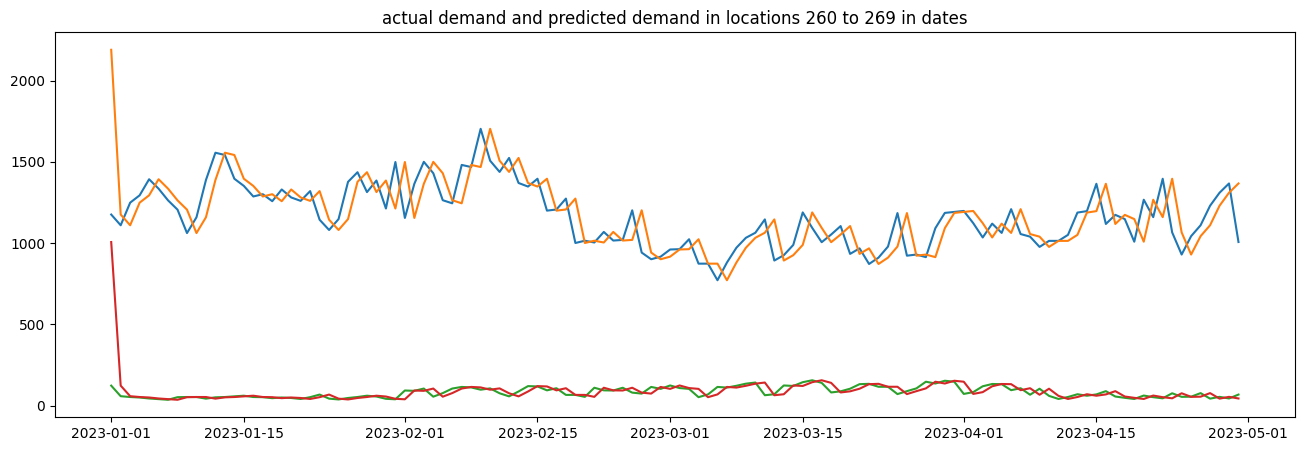

In [285]:
plot_actual_predicted(dataset, predicted_data)